# Global Forecasting Models: Time series with different lengths and different exogenous variables

When faced with a multi-series forecasting problem, it is common for the series to have varying lengths due to differences in the starting times of data recording. To address this scenario, the [ForecasterRecursiveMultiSeries](../user_guides/independent-multi-time-series-forecasting.html) class supports simultaneous modeling of multiple time series, even when they differ in length and use distinct exogenous variables. The various input formats can be combined, provided that the following requirements are met:

| Series type            | Exog type              | Index requirements                     |
|:----------------------:|:----------------------:|:---------------------------------------|
| `MultiIndex DataFrame` | `Wide DataFrame`       | pandas `DatetimeIndex`                 |
| `MultiIndex DataFrame` | `MultiIndex DataFrame` | pandas `DatetimeIndex`                 |
| `MultiIndex DataFrame` | `dict`                 | pandas `DatetimeIndex`                 |
| `dict`                 | `Wide DataFrame`       | `pandas DatetimeIndex` or `RangeIndex` |
| `dict`                 | `MultiIndex DataFrame` | pandas `DatetimeIndex`                 |
| `dict`                 | `dict`                 | `pandas DatetimeIndex` or `RangeIndex` |

Regarding the presence of missing values in the series, the `ForecasterRecursiveMultiSeries` class can handle all scenarios:

| Series values                            | Allowed |
|:----------------------------------------:|:-------:|
| `[NaN, NaN, NaN, NaN, 4, 5, 6, 7, 8, 9]` |✔️       |
| `[0, 1, 2, 3, 4, 5, 6, 7, 8, NaN]`       |✔️       |
| `[0, 1, 2, 3, 4, NaN, 6, 7, 8, 9]`       |✔️       |
| `[NaN, NaN, 2, 3, 4, NaN, 6, 7, 8, 9]`   |✔️       |

<div class="admonition note" name="html-admonition" style="background: rgba(0,191,191,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00bfa5; border-color: #00bfa5; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00bfa5;"></i>
    <b style="color: #00bfa5;">&#128161 Tip</b>
</p>

API Reference <a href="../api/forecasterrecursivemultiseries.html">ForecasterRecursiveMultiSeries</a>.

</div>

## Libraries and data

In [15]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
from lightgbm import LGBMRegressor
from skforecast.plot import set_dark_theme
from skforecast.preprocessing import (
    reshape_series_long_to_dict, 
    reshape_exog_long_to_dict, 
    RollingFeatures
)
from skforecast.recursive import ForecasterRecursiveMultiSeries
from skforecast.model_selection import (
    TimeSeriesFold,
    backtesting_forecaster_multiseries,
    bayesian_search_forecaster_multiseries
)

In this example, the data is stored in **long-format DataFrame**. The `series_id` column identifies the time series each observation belongs to, the `timestamp` column contains the corresponding dates, and the `value` column holds the observed values for each series. Each time series may have a different length.

The exogenous variables are stored in a separate **long-format DataFrame**. As with the main series, the `series_id` column indicates the associated time series, the `timestamp` column records the dates, and the remaining columns contain the values of the exogenous variables at each timestamp.

In [3]:
# Load time series of multiple lengths and exogenous variables
# ==============================================================================
series = pd.read_csv(
    'https://raw.githubusercontent.com/skforecast/skforecast-datasets/main/data/demo_multi_series.csv'
)
exog = pd.read_csv(
    'https://raw.githubusercontent.com/skforecast/skforecast-datasets/main/data/demo_multi_series_exog.csv'
)

series['timestamp'] = pd.to_datetime(series['timestamp'])
exog['timestamp'] = pd.to_datetime(exog['timestamp'])

display(series.head(3))
print("")
display(exog.head(3))

,series_id,timestamp,value
0,id_1000,2016-01-01,1012.500694
1,id_1000,2016-01-02,1158.500099
2,id_1000,2016-01-03,983.000099


,series_id,timestamp,sin_day_of_week,cos_day_of_week,air_temperature,wind_speed
0,id_1000,2016-01-01,-0.433884,-0.900969,6.416639,4.040115
1,id_1000,2016-01-02,-0.974928,-0.222521,6.366474,4.530395
2,id_1000,2016-01-03,-0.781831,0.623490,6.555272,3.273064


In terms of performance, using a <code>dict</code> is more efficient than a <code>MultiIndex DataFrame</code>, especially for larger datasets. This is because dictionaries enable faster access and manipulation of individual time series, without the structural overhead associated with DataFrames.

To convert the input data, the `reshape_series_long_to_dict` function can be used. It takes a **long-format pandas DataFrame** and returns a dictionary where each key corresponds to a series ID and each value is a `pandas Series` representing that time series.

Similarly, exogenous variables can be transformed into a dictionary using the `reshape_exog_long_to_dict` function. This function also takes a **long-format pandas DataFrame** as input and returns a dictionary in which the keys are the series IDs and the values are the corresponding exogenous variables, represented as either `pandas Series` or `DataFrames`.

In [4]:
# Transform series and exog to dictionaries
# ==============================================================================
series_dict = reshape_series_long_to_dict(
    data      = series,
    series_id = 'series_id',
    index     = 'timestamp',
    values    = 'value',
    freq      = 'D'
)

exog_dict = reshape_exog_long_to_dict(
    data      = exog,
    series_id = 'series_id',
    index     = 'timestamp',
    freq      = 'D'
)

╭──────────────────────────────── MissingValuesWarning ────────────────────────────────╮
│ Series 'id_1003' is incomplete. NaNs have been introduced after setting the          │
│ frequency.                                                                           │
│                                                                                      │
│ Category : MissingValuesWarning                                                      │
│ Location :                                                                           │
│ c:\Users\jaesc2\GitHub\skforecast\skforecast\preprocessing\preprocessing.py:481      │
│ Suppress : warnings.simplefilter('ignore', category=MissingValuesWarning)            │
╰──────────────────────────────────────────────────────────────────────────────────────╯

Some exogenous variables are intentionally omitted for series 1 and 3 to illustrate that each series can use a different set of exogenous variables.

In [5]:
# Drop some exogenous variables for series 'id_1000' and 'id_1003'
# ==============================================================================
exog_dict['id_1000'] = exog_dict['id_1000'].drop(columns=['air_temperature', 'wind_speed'])
exog_dict['id_1003'] = exog_dict['id_1003'].drop(columns=['cos_day_of_week'])

In [6]:
# Partition data in train and test
# ==============================================================================
end_train = '2016-07-31 23:59:00'
series_dict_train = {k: v.loc[: end_train,] for k, v in series_dict.items()}
exog_dict_train   = {k: v.loc[: end_train,] for k, v in exog_dict.items()}
series_dict_test  = {k: v.loc[end_train:,] for k, v in series_dict.items()}
exog_dict_test    = {k: v.loc[end_train:,] for k, v in exog_dict.items()}

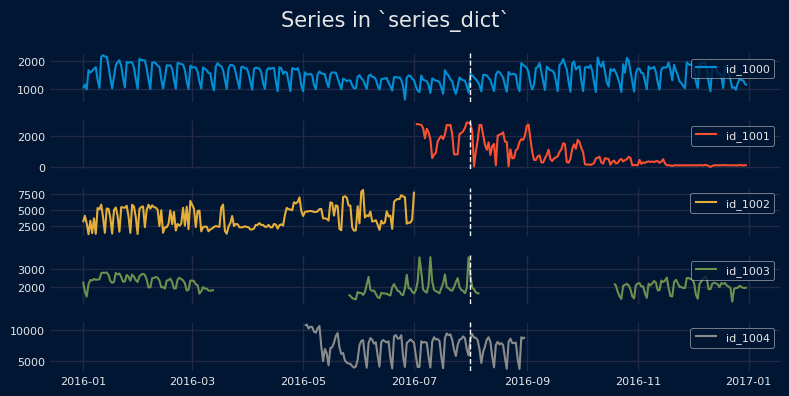

In [7]:
# Plot series
# ==============================================================================
set_dark_theme()
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, axs = plt.subplots(5, 1, figsize=(8, 4), sharex=True)

for i, s in enumerate(series_dict.values()):
    axs[i].plot(s, label=s.name, color=colors[i])
    axs[i].legend(loc='upper right', fontsize=8)
    axs[i].tick_params(axis='both', labelsize=8)
    axs[i].axvline(pd.to_datetime(end_train), color='white', linestyle='--', linewidth=1)  # End train

fig.suptitle('Series in `series_dict`', fontsize=15)
plt.tight_layout()

In [10]:
# Description of each partition
# ==============================================================================
for k in series_dict.keys():
    print(f"{k}:")
    try:
        print(
            f"\tTrain: len={len(series_dict_train[k])}, {series_dict_train[k].index[0]}"
            f" --- {series_dict_train[k].index[-1]}"
        )
    except IndexError:
        print("\tTrain: len=0")
    try:
        print(
            f"\tTest : len={len(series_dict_test[k])}, {series_dict_test[k].index[0]}"
            f" --- {series_dict_test[k].index[-1]}"
        )
    except IndexError:
        print("\tTest : len=0")

id_1000:
	Train: len=213, 2016-01-01 00:00:00 --- 2016-07-31 00:00:00
	Test : len=153, 2016-08-01 00:00:00 --- 2016-12-31 00:00:00
id_1001:
	Train: len=30, 2016-07-02 00:00:00 --- 2016-07-31 00:00:00
	Test : len=153, 2016-08-01 00:00:00 --- 2016-12-31 00:00:00
id_1002:
	Train: len=183, 2016-01-01 00:00:00 --- 2016-07-01 00:00:00
	Test : len=0
id_1003:
	Train: len=213, 2016-01-01 00:00:00 --- 2016-07-31 00:00:00
	Test : len=153, 2016-08-01 00:00:00 --- 2016-12-31 00:00:00
id_1004:
	Train: len=91, 2016-05-02 00:00:00 --- 2016-07-31 00:00:00
	Test : len=31, 2016-08-01 00:00:00 --- 2016-08-31 00:00:00


In [11]:
# Exogenous variables for each series
# ==============================================================================
for k in series_dict.keys():
    print(f"{k}:")
    try:
        print(f"\t{exog_dict[k].columns.to_list()}")
    except IndexError:
        print("\tNo exogenous variables")

id_1000:
	['sin_day_of_week', 'cos_day_of_week']
id_1001:
	['sin_day_of_week', 'cos_day_of_week', 'air_temperature', 'wind_speed']
id_1002:
	['sin_day_of_week', 'cos_day_of_week', 'air_temperature', 'wind_speed']
id_1003:
	['sin_day_of_week', 'air_temperature', 'wind_speed']
id_1004:
	['sin_day_of_week', 'cos_day_of_week', 'air_temperature', 'wind_speed']


## Train and predict

The `fit` method is used to train the model, it is passed the dictionary of series and the dictionary of exogenous variables where the keys of each dictionary are the names of the series.

In [12]:
# Fit forecaster
# ==============================================================================
window_features = RollingFeatures(stats=['mean', 'mean'], window_sizes=[7, 14])
forecaster = ForecasterRecursiveMultiSeries(
                 regressor          = LGBMRegressor(random_state=123, verbose=-1, max_depth=5), 
                 lags               = 14, 
                 window_features    = window_features,
                 encoding           = "ordinal", 
                 dropna_from_series = False
             )

forecaster.fit(series=series_dict_train, exog=exog_dict_train, suppress_warnings=True)
forecaster

============================== 
ForecasterRecursiveMultiSeries 
============================== 
Regressor: LGBMRegressor 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
Window features: ['roll_mean_7', 'roll_mean_14'] 
Window size: 14 
Series encoding: ordinal 
Series names (levels): id_1000, id_1001, id_1002, id_1003, id_1004 
Exogenous included: True 
Exogenous names: 
    sin_day_of_week, cos_day_of_week, air_temperature, wind_speed 
Transformer for series: None 
Transformer for exog: None 
Weight function included: False 
Series weights: None 
Differentiation order: None 
Training range: 
    'id_1000': ['2016-01-01', '2016-07-31'], 'id_1001': ['2016-07-02',
    '2016-07-31'], 'id_1002': ['2016-01-01', '2016-07-01'], 'id_1003':
    ['2016-01-01', '2016-07-31'], 'id_1004': ['2016-05-02', '2016-07-31'] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: 
    {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0,
    'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 5,
    'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0,
    'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None,
    'random_state': 123, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0,
    'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1} 
fit_kwargs: {} 
Creation date: 2025-06-25 16:28:24 
Last fit date: 2025-06-25 16:28:26 
Skforecast version: 0.17.0 
Python version: 3.11.10 
Forecaster id: None

Only series whose **last window** ends at the same datetime index can be predicted simultaneously. If `levels=None`, any series that does not extend to the maximum datetime index is excluded from the prediction.

In this example, series `'id_1002'` is excluded because its last available observation occurs before the latest index shared by the other series.

In [ ]:
# Internal last window maximum index
# ==============================================================================
pprint(
    {k: v.index[-1] for k, v in forecaster.last_window_.items() if v is not None}
)

{'id_1000': Timestamp('2016-07-31 00:00:00'),
 'id_1001': Timestamp('2016-07-31 00:00:00'),
 'id_1002': Timestamp('2016-07-01 00:00:00'),
 'id_1003': Timestamp('2016-07-31 00:00:00'),
 'id_1004': Timestamp('2016-07-31 00:00:00')}


In [20]:
# Predict
# ==============================================================================
predictions = forecaster.predict(steps=5, exog=exog_dict_test, suppress_warnings=True)
predictions.head(9)

,level,pred
2016-08-01,id_1000,1453.312971
2016-08-01,id_1001,2849.347882
2016-08-01,id_1003,2706.851726
2016-08-01,id_1004,7496.555367
2016-08-02,id_1000,1440.763196
2016-08-02,id_1001,2947.579536
2016-08-02,id_1003,2310.075968
2016-08-02,id_1004,8685.425990
2016-08-03,id_1000,1410.151437


## Missing values in the series

When working with time series of different lengths, it is common for some series to contain missing values. Since not all regressors can handle missing data, the `dropna_from_series` argument controls how missing values in the predictors are treated when building the training matrices.

- If set to `False` (default), `NaN` values in `X_train` are retained, and a warning is issued.

- If set to `True`, rows with `NaN` values in `X_train` are dropped, and the corresponding rows in y_train are removed as well. A warning is also issued.

Regardless of this setting, any `NaN` values in `y_train` are always dropped, along with the corresponding rows in `X_train`, as the target variable cannot contain missing values.

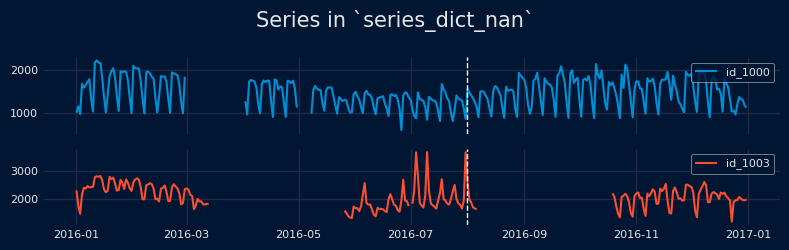

In [21]:
# Sample data with interspersed NaNs
# ==============================================================================
series_dict_nan = {
    'id_1000': series_dict['id_1000'].copy(),
    'id_1003': series_dict['id_1003'].copy()
}

# Create NaNs
series_dict_nan['id_1000'].loc['2016-03-01':'2016-04-01',] = np.nan
series_dict_nan['id_1000'].loc['2016-05-01':'2016-05-07',] = np.nan
series_dict_nan['id_1003'].loc['2016-07-01',] = np.nan

# Plot series
# ==============================================================================
fig, axs = plt.subplots(2, 1, figsize=(8, 2.5), sharex=True)

for i, s in enumerate(series_dict_nan.values()):
    axs[i].plot(s, label=s.name, color=colors[i])
    axs[i].legend(loc='upper right', fontsize=8)
    axs[i].tick_params(axis='both', labelsize=8)
    axs[i].axvline(pd.to_datetime(end_train), color='white', linestyle='--', linewidth=1)  # End train

fig.suptitle('Series in `series_dict_nan`', fontsize=15)
plt.tight_layout()

When `dropna_from_series=False,` any `NaN` values in `X_train` are retained, and a warning is issued. This setting is useful when the user intends to preserve missing values in the input series and use a regressor that can handle them natively.

In [22]:
# Create Matrices, dropna_from_series = False
# ==============================================================================
forecaster = ForecasterRecursiveMultiSeries(
                 regressor          = LGBMRegressor(random_state=123, verbose=-1, max_depth=5), 
                 lags               = 3, 
                 encoding           = "ordinal", 
                 dropna_from_series = False
             )

X, y = forecaster.create_train_X_y(series=series_dict_nan)

display(X.head(3))
print("Observations per series:")
print(X['_level_skforecast'].value_counts())
print("")
print("NaNs per series:")
print(X.isnull().sum())

╭──────────────────────────────── MissingValuesWarning ────────────────────────────────╮
│ NaNs detected in `y_train`. They have been dropped because the target variable       │
│ cannot have NaN values. Same rows have been dropped from `X_train` to maintain       │
│ alignment. This is caused by series with interspersed NaNs.                          │
│                                                                                      │
│ Category : MissingValuesWarning                                                      │
│ Location :                                                                           │
│ c:\Users\jaesc2\GitHub\skforecast\skforecast\recursive\_forecaster_recursive_multise │
│ ries.py:1223                                                                         │
│ Suppress : warnings.simplefilter('ignore', category=MissingValuesWarning)            │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────── MissingValuesWarning ────────────────────────────────╮
│ NaNs detected in `X_train`. Some regressors do not allow NaN values during training. │
│ If you want to drop them, set `forecaster.dropna_from_series = True`.                │
│                                                                                      │
│ Category : MissingValuesWarning                                                      │
│ Location :                                                                           │
│ c:\Users\jaesc2\GitHub\skforecast\skforecast\recursive\_forecaster_recursive_multise │
│ ries.py:1245                                                                         │
│ Suppress : warnings.simplefilter('ignore', category=MissingValuesWarning)            │
╰──────────────────────────────────────────────────────────────────────────────────────╯

,lag_1,lag_2,lag_3,_level_skforecast
2016-01-04,983.000099,1158.500099,1012.500694,0
2016-01-05,1675.750496,983.000099,1158.500099,0
2016-01-06,1586.250694,1675.750496,983.000099,0


Observations per series:
_level_skforecast
0    324
1    216
Name: count, dtype: int64

NaNs per series:
lag_1                 5
lag_2                 9
lag_3                13
_level_skforecast     0
dtype: int64


When `dropna_from_series=True`, any `NaN` values in `X_train` are removed, and a warning is issued. This option is useful when the chosen regressor cannot handle missing values and requires a fully populated training matrix.

In [23]:
# Create Matrices, dropna_from_series = False
# ==============================================================================
forecaster = ForecasterRecursiveMultiSeries(
                 regressor          = LGBMRegressor(random_state=123, verbose=-1, max_depth=5), 
                 lags               = 3, 
                 encoding           = "ordinal", 
                 dropna_from_series = True
             )

X, y = forecaster.create_train_X_y(series=series_dict_nan)

display(X.head(3))
print("Observations per series:")
print(X['_level_skforecast'].value_counts())
print("")
print("NaNs per series:")
print(X.isnull().sum())

╭──────────────────────────────── MissingValuesWarning ────────────────────────────────╮
│ NaNs detected in `y_train`. They have been dropped because the target variable       │
│ cannot have NaN values. Same rows have been dropped from `X_train` to maintain       │
│ alignment. This is caused by series with interspersed NaNs.                          │
│                                                                                      │
│ Category : MissingValuesWarning                                                      │
│ Location :                                                                           │
│ c:\Users\jaesc2\GitHub\skforecast\skforecast\recursive\_forecaster_recursive_multise │
│ ries.py:1223                                                                         │
│ Suppress : warnings.simplefilter('ignore', category=MissingValuesWarning)            │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────── MissingValuesWarning ────────────────────────────────╮
│ NaNs detected in `X_train`. They have been dropped. If you want to keep them, set    │
│ `forecaster.dropna_from_series = False`. Same rows have been removed from `y_train`  │
│ to maintain alignment. This caused by series with interspersed NaNs.                 │
│                                                                                      │
│ Category : MissingValuesWarning                                                      │
│ Location :                                                                           │
│ c:\Users\jaesc2\GitHub\skforecast\skforecast\recursive\_forecaster_recursive_multise │
│ ries.py:1236                                                                         │
│ Suppress : warnings.simplefilter('ignore', category=MissingValuesWarning)            │
╰──────────────────────────────────────────────────────────────────────────────────────╯

,lag_1,lag_2,lag_3,_level_skforecast
2016-01-04,983.000099,1158.500099,1012.500694,0
2016-01-05,1675.750496,983.000099,1158.500099,0
2016-01-06,1586.250694,1675.750496,983.000099,0


Observations per series:
_level_skforecast
0    318
1    207
Name: count, dtype: int64

NaNs per series:
lag_1                0
lag_2                0
lag_3                0
_level_skforecast    0
dtype: int64


During the training process, the warnings can be suppressed by setting `suppress_warnings = True`.

In [14]:
# Suppress warnings during fit method
# ==============================================================================
forecaster.fit(series=series_dict_nan, suppress_warnings=True)
forecaster

============================== 
ForecasterRecursiveMultiSeries 
============================== 
Regressor: LGBMRegressor 
Lags: [1 2 3] 
Window features: None 
Window size: 3 
Series encoding: ordinal 
Series names (levels): id_1000, id_1003 
Exogenous included: False 
Exogenous names: None 
Transformer for series: None 
Transformer for exog: None 
Weight function included: False 
Series weights: None 
Differentiation order: None 
Training range: 
    'id_1000': ['2016-01-01', '2016-12-31'], 'id_1003': ['2016-01-01', '2016-12-31'] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: 
    {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0,
    'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 5,
    'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0,
    'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None,
    'random_state': 123, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0,
    'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1} 
fit_kwargs: {} 
Creation date: 2025-05-01 15:10:01 
Last fit date: 2025-05-01 15:10:01 
Skforecast version: 0.16.0 
Python version: 3.12.9 
Forecaster id: None

## Backtesting

As with the `predict` method, the `levels` parameter must be specified when performing [backtesting](../user_guides/backtesting.html). When backtesting time series of varying lengths, two important behaviors should be considered:

+ **Handling missing values in the series:** Backtesting only produces predictions for the date-times that are present in each individual series. If there are gaps in the validation or test sets, no predictions are generated for those missing periods. This ensures that evaluation metrics are not distorted by the absence of true values.

+ **Size of the training set:** If the `initial_train_size` parameter is specified as an `integer`, it is applied relative to the earliest timestamp across all series. Consequently, series that start later may have a shorter effective training window, or even no available training data during the initial folds. Alternatively, `initial_train_size` can be specified as a datetime, which can make the training window easier to interpret and align with specific points in time.

In [26]:
# Backtesting
# ==============================================================================
forecaster = ForecasterRecursiveMultiSeries(
                 regressor          = LGBMRegressor(random_state=123, verbose=-1, max_depth=5), 
                 lags               = 14, 
                 window_features    = RollingFeatures(stats=['mean', 'mean'], window_sizes=[7, 14]),
                 encoding           = "ordinal", 
                 dropna_from_series = False
             )

cv = TimeSeriesFold(
         steps              = 24,
         initial_train_size = "2016-07-31 23:59:00",
     )

metrics_levels, backtest_predictions = backtesting_forecaster_multiseries(
    forecaster            = forecaster,
    series                = series_dict,
    exog                  = exog_dict,
    cv                    = cv,
    levels                = None,
    metric                = "mean_absolute_error",
    add_aggregated_metric = True,
    suppress_warnings     = True
)

display(metrics_levels)
backtest_predictions

  0%|          | 0/7 [00:00<?, ?it/s]

,levels,mean_absolute_error
0,id_1000,167.502214
1,id_1001,1103.313887
2,id_1002,NaN
3,id_1003,280.492603
4,id_1004,711.078359
5,average,565.596766
6,weighted_average,572.944127
7,pooling,572.944127


,level,pred
2016-08-01,id_1000,1453.312971
2016-08-01,id_1001,2849.347882
2016-08-01,id_1003,2706.851726
2016-08-01,id_1004,7496.555367
2016-08-02,id_1000,1440.763196
...,...,...
2016-12-30,id_1001,1132.535774
2016-12-30,id_1003,2089.261345
2016-12-31,id_1000,1393.128313
2016-12-31,id_1001,1106.034061


Note that if a series has no observations in the test set, the backtesting process will not generate any predictions for that series, and the corresponding metric will be `NaN`. This is the case for series `'id_1002'` in the current example.

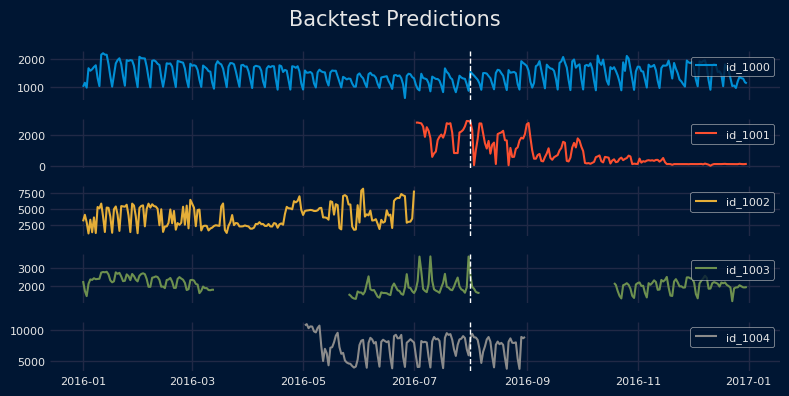

In [28]:
# Plot backtesting predictions
# ==============================================================================
fig, axs = plt.subplots(5, 1, figsize=(8, 4), sharex=True)

for i, s in enumerate(series_dict.keys()):
    axs[i].plot(series_dict[s], label=series_dict[s].name, color=colors[i])
    axs[i].axvline(pd.to_datetime(end_train), color='white', linestyle='--', linewidth=1)  # End train
    try:
        axs[i].plot(backtest_predictions[s], label='prediction', color="white")
    except KeyError:
        pass
    axs[i].legend(loc='upper right', fontsize=8)
    axs[i].tick_params(axis='both', labelsize=8)

fig.suptitle('Backtest Predictions', fontsize=15)
plt.tight_layout()

## Hyperparameter search and lags selection

Hyperparameter tuning consists of systematically evaluating combinations of hyperparameters (including lags) to find the configuration that yields the best predictive performance. The **skforecast** library supports several tuning strategies: **grid search**, **random search**, and **Bayesian search**. These strategies can be used with either [backtesting](../user_guides/backtesting.html) or [one-step-ahead validation](../user_guides/hyperparameter-tuning-and-lags-selection.html#one-step-ahead-validation) to determine the optimal parameter set for a given forecasting task.

The functions `grid_search_forecaster_multiseries`, `random_search_forecaster_multiseries` and `bayesian_search_forecaster_multiseries` from the `model_selection` module allow for **lags and hyperparameter optimization**.

The `levels` argument is crucial in these functions, as it specifies **which time series are considered** during the optimization:

+ If `levels` is a `list`, the function searches for the configuration that minimizes the aggregated error across the selected series.

+ If `levels = None`, all available series are used in the optimization.

+ If `levels = 'item_1'` (equivalent to `levels = ['item_1']`), the optimization is based solely on the error of that specific series, and the returned metric corresponds to it.

When optimizing across multiple series, the resulting metrics must be **aggregated**. The available methods are:

+ `'average'`, the average (arithmetic mean) of all series (`levels`).

+ `'weighted_average'`, the average of the metrics weighted by the number of predicted values of each series (`levels`).

+ `'pooling'`, the values of all series (`levels`) are pooled and then the metric is calculated.

If a `list` of aggregation methods is provided to the `aggregate_metric` argument, all are computed, but only the **first method** is used to select the **best configuration**.

The following example demonstrates how to use `grid_search_forecaster_multiseries` to find the best lags and hyperparameters for all series (all `levels`) using `'weighted_average'` as the aggregation strategy.

In [ ]:
# Bayesian search hyperparameters and lags with Optuna
# ==============================================================================
forecaster = ForecasterRecursiveMultiSeries(
                 regressor          = LGBMRegressor(random_state=123, verbose=-1), 
                 lags               = 14, 
                 window_features    = RollingFeatures(stats=['mean', 'mean'], window_sizes=[7, 14]),
                 encoding           = "ordinal", 
                 dropna_from_series = False
             )

# Search space
def search_space(trial):
    search_space  = {
        'lags'            : trial.suggest_categorical('lags', [7, 14]),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 10, 30),
        'max_depth'       : trial.suggest_int('max_depth', 3, 7)
    }

    return search_space

cv = TimeSeriesFold(
         steps              = 24,
         initial_train_size = "2016-07-31 23:59:00",
     )

results, best_trial = bayesian_search_forecaster_multiseries(
    forecaster        = forecaster,
    series            = series_dict,
    exog              = exog_dict,
    search_space      = search_space,
    cv                = cv,
    levels            = None,
    metric            = 'mean_absolute_error',
    n_trials          = 10,
    suppress_warnings = True
)

results.head(4)

  0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
  Parameters: {'min_samples_leaf': 29, 'max_depth': 5}
  Backtesting metric: 531.5731935466865
  Levels: ['id_1000', 'id_1001', 'id_1002', 'id_1003', 'id_1004']



,levels,lags,params,mean_absolute_error__weighted_average,mean_absolute_error__average,mean_absolute_error__pooling,min_samples_leaf,max_depth
0,"[id_1000, id_1001, id_1002, id_1003, id_1004]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'min_samples_leaf': 29, 'max_depth': 5}",531.573194,510.885119,510.885119,29,5
1,"[id_1000, id_1001, id_1002, id_1003, id_1004]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'min_samples_leaf': 11, 'max_depth': 5}",542.700963,557.169748,557.169748,11,5
2,"[id_1000, id_1001, id_1002, id_1003, id_1004]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'min_samples_leaf': 18, 'max_depth': 4}",572.011630,559.198862,559.198862,18,4
3,"[id_1000, id_1001, id_1002, id_1003, id_1004]","[1, 2, 3, 4, 5, 6, 7]","{'min_samples_leaf': 30, 'max_depth': 6}",591.817179,595.234722,595.234722,30,6


## Categorical variables

<div class="admonition note" name="html-admonition" style="background: rgba(255,145,0,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #ff9100; border-color: #ff9100; padding-left: 10px; padding-right: 10px">

<p class="title">
    <i style="font-size: 18px; color:#ff9100; border-color: #ff1744;"></i>
    <b style="color: #ff9100;"> <span style="color: #ff9100;">&#9888;</span> Warning</b>
</p>

Starting with version <code>0.13.0</code>, the <code>ForecasterRecursiveMultiSeries</code> class can use <code>encoding='ordinal_category'</code> for encoding time series identifiers. This approach creates a new column (<i>_level_skforecast</i>) of type pandas <code>category</code>. Consequently, the regressors must be able to handle categorical variables. If the regressors do not support categorical variables, the user should set the encoding to <code>'ordinal'</code> or <code>'onehot'</code> for compatibility.

<p>Some examples of regressors that support categorical variables and how to enable them are:</p>

<strong>HistGradientBoostingRegressor</strong> 

```python
HistGradientBoostingRegressor(categorical_features="from_dtype")
```

<strong>LightGBM</strong>

<code>LGBMRegressor</code> does not allow configuration of categorical features during initialization, but rather in its <code>fit</code> method. Therefore, use Forecaster' argument <code>fit_kwargs = {'categorical_feature':'auto'}</code>. This is the default behavior of <code>LGBMRegressor</code> if no indication is given.

<strong>XGBoost</strong>
```python
XGBRegressor(enable_categorical=True)
```

</div>